# Transformer Application

## Configuration

### Hyperparameters

In [2]:
from CustomLoss import CustomEmbeddingSliceLoss
import torch.nn as nn
import matplotlib.pyplot as plt

# HYPERPARAMETERS
BATCH_SIZE = 32
LEARNING_RATE = 0.0005

#transformer
NUM_HEADS = 6 # Dividers of 170: {1; 2; 3; 5; 6; 9; 10; 15; 18; 27; 30; 45; 54; 90; 135; 270}
NUM_ENCODER_LAYERS = 8
NUM_DECODER_LAYERS = 8
DROPOUT=0.25

# Methods
loss_function = CustomEmbeddingSliceLoss()

### Constants

In [3]:
# CONSTANTS
FEATURE_DIM = 282

## Load Prepared Tensors from Disk
Run file `prototype_dataset.ipynb` first

In [4]:
import torch

train_sequence_input = torch.load('data/prototype_dataset/train_sequence_input.pt')
train_sequence_output = torch.load('data/prototype_dataset/train_sequence_output.pt')
test_sequence_input = torch.load('data/prototype_dataset/test_sequence_input.pt')
test_sequence_output = torch.load('data/prototype_dataset/test_sequence_output.pt')

In [5]:
from dataset_helper import warn_if_contains_NaN

warn_if_contains_NaN(train_sequence_input)
warn_if_contains_NaN(train_sequence_output)
warn_if_contains_NaN(test_sequence_input)
warn_if_contains_NaN(test_sequence_output)

In [6]:
print(train_sequence_input.size())
print(train_sequence_output.size())
print(test_sequence_input.size())
print(test_sequence_output.size())

torch.Size([294, 100, 282])
torch.Size([294, 100, 282])
torch.Size([66, 100, 282])
torch.Size([66, 100, 282])


## Build Dataloader with Batches

In [7]:
from torch.utils.data import DataLoader, TensorDataset

train_dataloader = DataLoader(TensorDataset(train_sequence_input.float(), train_sequence_output.float()),
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True)
val_dataloader = DataLoader(TensorDataset(test_sequence_input.float(), test_sequence_output.float()),
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            drop_last=True)

In [8]:
len(train_dataloader)

9

## Initialize

In [9]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)
torch.__version__

'2.1.1'

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [11]:
from torch import nn
from AnimationTransformer import AnimationTransformer

model = AnimationTransformer(
    dim_model=FEATURE_DIM,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout_p=DROPOUT,
    use_positional_encoder=True
).to(device)

# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_param = sum(p.numel() for p in model.parameters())
print(f"The model has {total_param} trainable parameters")

The model has 26203496 trainable parameters


## Training

In [12]:
from AnimationTransformer import fit

train_loss_list, validation_loss_list = fit(model,
                                            optimizer,
                                            loss_function,
                                            train_dataloader,
                                            val_dataloader,
                                            epochs=2,
                                            device=device)

Training and validating model
------------------------- Epoch 1 -------------------------


c:\Users\okan2\anaconda3\envs\animationSVG\lib\site-packages\torch\nn\functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


>> 1: Time per Batch  1.56s | Total expected  0.23 min | Remaining  0.21 min 
>> Epoch time: 0.18 min


c:\Users\okan2\anaconda3\envs\animationSVG\lib\site-packages\torch\nn\modules\transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training loss: 18.1837
Validation loss: 14.9766

------------------------- Epoch 2 -------------------------
>> 1: Time per Batch  1.20s | Total expected  0.18 min | Remaining  0.16 min 
>> Epoch time: 0.17 min
Training loss: 17.2821
Validation loss: 14.8866



In [13]:
# Define the number of additional epochs you want to train for
additional_epochs = 2

# Continue training the model for more epochs
new_train_loss, new_validation_loss = fit(model,
                                          optimizer,
                                          loss_function,
                                          train_dataloader,
                                          val_dataloader,
                                          epochs=additional_epochs,
                                          device=device)

# Extend the original loss lists with the new loss values
train_loss_list.extend(new_train_loss)
validation_loss_list.extend(new_validation_loss)

Training and validating model
------------------------- Epoch 1 -------------------------
>> 1: Time per Batch  1.23s | Total expected  0.18 min | Remaining  0.16 min 
>> Epoch time: 0.17 min
Training loss: 17.7498
Validation loss: 14.8354

------------------------- Epoch 2 -------------------------
>> 1: Time per Batch  1.25s | Total expected  0.19 min | Remaining  0.17 min 
>> Epoch time: 0.17 min
Training loss: 17.5827
Validation loss: 14.8297



In [14]:
print("Train\n", "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in train_loss_list]))

Train
 18,1837; 17,2821; 17,7498; 17,5827


In [15]:
print("Validation\n", "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in validation_loss_list]))

Validation
 14,9766; 14,8866; 14,8354; 14,8297


## Training and Validation Loss Plot

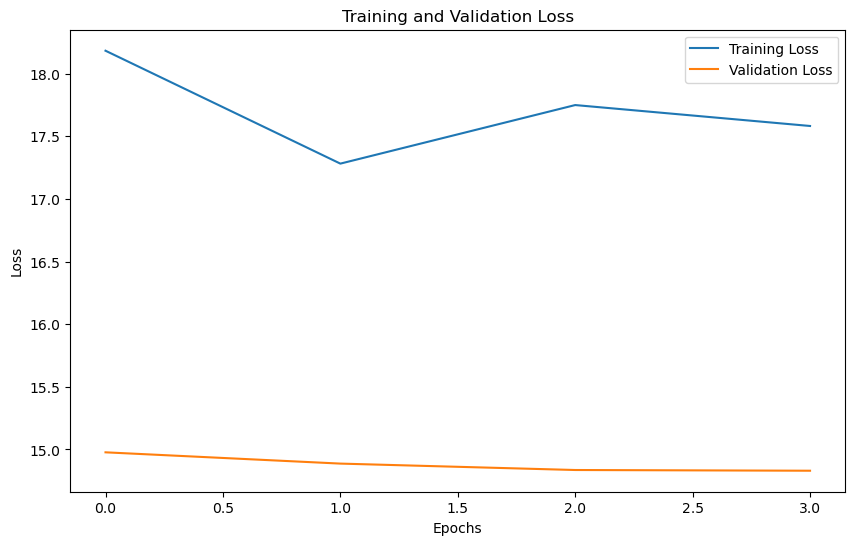

In [16]:
# # Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_loss_list, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Prediction

In [17]:
# Sequences with long input
test_sequence_input[50, :, 0] # 50, 10, 220, 222, 600

tensor([  -1.4797,   -1.4797, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.000

In [18]:
# check sequence length / embedding
print(test_sequence_output[50, :, -26:])
print(test_sequence_input [50, :, -26:])

tensor([[   1.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    1.0000,    0.0000,  ...,   83.5821,   19.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,   60.3084,   20.0000,
            0.0000],
        ...,
        [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
         -100.0000],
        [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
         -100.0000],
        [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
         -100.0000]])
tensor([[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        ...,
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.]], dtype=torch.float64)


In [19]:
# Create a tensor of zeros with 270 elements
sos_token = torch.zeros(282)
# Set the value at the 256 index to 1
sos_token[256] = 1

In [20]:
from AnimationTransformer import predict

result = predict(model, test_sequence_input[10], sos_token=sos_token, device=device, max_length=100, eos_scaling=0.01)
print(result, result.shape)

2: Path 0 (15.839) got animation 2 (0.212%) with parameters [1.0, 0.0, -1.0, -1.0, 0.58, 0.09, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
3: Path 0 (15.839) got animation 2 (0.212%) with parameters [1.0, 0.0, -1.0, -1.0, 0.58, 0.09, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
4: Path 0 (15.839) got animation 2 (0.212%) with parameters [1.0, 0.0, -1.0, -1.0, 0.58, 0.09, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
5: Path 0 (15.839) got animation 2 (0.212%) with parameters [1.0, 0.0, -1.0, -1.0, 0.58, 0.09, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
6: Path 0 (15.839) got animation 2 (0.212%) with parameters [1.0, 0.0, -1.0, -1.0, 0.58, 0.09, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
7: Path 0 (15.839) got animation 2 (0.212%) with parameters [1.0, 0.0, -1.0, -1.0, 0.58, 0.09, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
8: Path 0 (15.839) got animation 2 (0.212%) with parameters [1.0, 0.0, -1.0, -1.0, 0.58, 0.09, -1.0, -1.0,

In [ ]:
result = result.cpu()
model_parameters = result[:,1:,:12].squeeze(0).detach().numpy()
print(model_parameters, model_parameters.shape)

model_parameters = pd.DataFrame(model_parameters)
model_parameters["model_output"] = model_parameters.apply(lambda row: row.tolist(), axis=1)

# Apply the custom function to the "model_output" column
model_parameters = model_parameters[['model_output']]

model_parameters["animation_id"] = range(0, len(model_parameters))
print(model_parameters, model_parameters.shape)
from src.postprocessing.postprocessing import *

postprocess_logo(model_parameters, "data/1_inserted_animation_id/logo_104.svg")

# Hyperparameter Tuning

In [ ]:
from AnimationTransformer import validation_loop, train_loop
import optuna
from torch.utils.data import DataLoader

MAX_EPOCHS = 5

def objective(trial):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_encoder_layers = trial.suggest_categorical('num_encoder_layers', [2, 4, 6])
    num_decoder_layers = trial.suggest_categorical('num_decoder_layers', [4, 6, 8])
    # batch_size = trial.suggest_categorical('batch_size', [64])
    num_heads = trial.suggest_categorical('num_heads', [2, 3, 6])
    dropout = trial.suggest_float('dropout', 0.1, 0.3)
    use_positional_encoder = trial.suggest_categorical('pos_encoder_max_len', [True, False])
    
    print(f'Parameters selected')
    print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; use_positional_encoder; dropout')
    print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate}; {num_heads}; {use_positional_encoder}; {dropout}'.replace('.', ','))
    
    # Instantiate the model with suggested hyperparameters
    model = AnimationTransformer(
        dim_model=FEATURE_DIM,
        num_heads=num_heads,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dropout_p=dropout,
        use_positional_encoder=use_positional_encoder
    ).to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_list, validation_loss_list = [], []

    validation_loss = -1
    # Training loop with early stopping, validation, etc.
    for epoch in range(MAX_EPOCHS):
        print(f' =========== EPOCH {epoch} ===========')
        
        train_loss = train_loop(model, optimizer, loss_function, train_dataloader, device)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_function, val_dataloader, device)
        validation_loss_list += [validation_loss]
        
        print(f'Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')
        
        # Report the validation loss to Optuna
        trial.report(validation_loss, epoch)
        
        # Implement early stopping logic
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    print(f'Best validation loss: {validation_loss}')
    print(f'num_encoder_layers; num_decoder_layers; learning_rate; num_heads; use_positional_encoder; dropout;')
    print(f'{num_encoder_layers}; {num_decoder_layers}; {learning_rate:.8f}; {num_heads}; {use_positional_encoder}; {dropout:.8f}; Validation; '.replace('.', ','),
          "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in validation_loss_list]))
    print(f' ; ; ; ; ; Train; ',
          "; ".join([str(f"{loss:.4f}").replace('.', ',') for loss in train_loss_list]))
    
    return validation_loss

Used:
- pick_and_animate_from_8     First Run
- pick_and_animate_from_8_v3  First Main Run

In [ ]:
my_study = optuna.create_study(
    direction='minimize',
    study_name='pick_and_animate_from_8', # IMPORTANT: Chance Name when new Dataset
    storage='sqlite:///animate_svg_optuna.db',
    load_if_exists=True
)

In [ ]:
#study = optuna.create_study(direction='minimize')
my_study.optimize(objective, n_trials=100)

In [ ]:
print("Best trial:")
trial = my_study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(my_study)

In [ ]:
plot_param_importances(my_study)

In [ ]:
from optuna.visualization import plot_slice

plot_slice(my_study)

In [ ]:
from optuna.visualization import plot_timeline

plot_timeline(my_study)

## Reinforcement

In [ ]:
import gym
from gym import spaces
import numpy as np
import random
import CustomLoss



class CustomEnv(gym.Env):
    def __init__(self, startingState : torch.tensor):
        super(CustomEnv, self).__init__()

        # Define your action and observation space
        self.action_space = spaces.Discrete(6)

        # Example: 6-dimensional observation space represented by a Box
        self.observation_space = startingState

        # Define any other environment parameters
        self.max_steps = 100
        self.current_step = 0

    def reset(self, startingState : torch.tensor):
        # Reset the environment to its initial state
        self.current_step = 0
        self.observation_space = startingState
        # Return the initial observation
        return self.observation_space

    def step(self, action):
        ##### STATE = APPLY ACTION TO OBSERVATION #####
        state = np.random.rand(6, 6)
        
        reward = np.random.rand()
        
        done = self.current_step >= self.max_steps
        self.current_step += 1
        return state, reward, done



class Agent:
    def __init__(self, input : torch.tensor):

        self.input = input
        self.X = input[0:1, :, :].to(device)
        self.y = self.randomAnimation(self.X).to(device)

        self.currentLogo = 0

        self.epsilon = 0.8

        self.model = AnimationTransformer(
            dim_model=FEATURE_DIM,
            num_heads=NUM_HEADS,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            num_decoder_layers=NUM_DECODER_LAYERS,
            dropout_p=DROPOUT,
            use_positional_encoder=True
            ).to(device)
        self.opt = torch.optim.SGD(self.model.parameters(), lr=0.005)
        self.loss_fn = CustomEmbeddingSliceLoss()

        self.total_loss = 0
    
    def randomAnimation(self, t : torch.tensor):
        print(t.shape)
        for i in range(t.shape[0]):
            for j in range(t.shape[1]):
                type = random.randint(0,5)
                if t[i,j,256+type] != 50 and t[i,j,256+type] != 10 and t[i,j,256+type] != 30:
                    t[i,j,256+type] = 1
                    for d in range (261, 268):
                        t[i,j,d] = random.random()
        return t
    
    def trainStep(self):

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = self.y[:,:-1,:]
        y_expected = self.y[:,1:,:]
            
        # Get mask to mask out the next words
        sequence_length = self.y.size(1)
        tgt_mask = self.model.get_tgt_mask(sequence_length).to(device)
        pad_mask_src = self.model.create_pad_mask(self.X, 10).to(device)
        pad_mask_tgt = self.model.create_pad_mask(self.y, 10).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = self.model(self.X, self.y, tgt_mask, src_pad_mask=pad_mask_src, tgt_pad_mask=pad_mask_tgt)
        

        sm = nn.Softmax(dim=2)
        next_item = sm(pred[:,:,256:262])
        #print(next_item, next_item.shape)
        animation_type = torch.argmax(next_item, dim=2)[0].tolist()
        #print(animation_type)

        for k in range(len(animation_type)):
            for i in range(0,6):
                if i == animation_type[k]:
                    pred[:,k,256+i] = 1
                else:
                    pred[:,k,256+i] = 0
                    
        print(pred, pred.shape)
        loss = self.loss_fn(pred, self.y)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        self.total_loss += loss.detach().item()

        return pred
    
    def chooseAction(self, pred : torch.tensor):
        
        q = random.random()

        if q > self.epsilon:
            print("explore")
        else:
            print("exploit")

        return random.randint(0,5)

    def nextLogo(self):
        self.X = input[self.currentLogo:self.currentLogo+1, :, :].to(device)
        self.y = self.randomAnimation(self.X).to(device)

        self.currentLogo = self.currentLogo+1
    


def reinforce():

    env = CustomEnv(inpTensor2[0:1, :, :])
    agent = Agent(inpTensor2)

    totalReward = 0
    for i in range(1, inpTensor2.shape[0]):
        
        print(i)
        observation = env.reset(inpTensor2[i-1:i, :, :])

        done = False
        while not done:
                
            current = agent.trainStep()
            action = agent.chooseAction(current)

            state, reward, done = env.step(action)
            totalReward += reward

        agent.nextLogo()

reinforce()
    


## Animation Creation